In [3]:
import io
import numpy as np
import pandas as pd
import requests
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, train_test_split
import zipfile
import seaborn as sns

In [6]:
# Download the zip file
url = 'https://archive.ics.uci.edu/static/public/222/bank+marketing.zip'
response = requests.get(url)

# First, extract the outer zip file
with zipfile.ZipFile(io.BytesIO(response.content)) as outer_zip:
    # Extract the inner bank.zip file
    with outer_zip.open('bank.zip') as inner_zip_file:
        with zipfile.ZipFile(inner_zip_file) as inner_zip:
            # Read the CSV directly from the inner zip file
            with inner_zip.open('bank.csv') as csv_file:
                df = pd.read_csv(csv_file, sep=';')

# Display first few rows
print("\nFirst 5 rows of the dataset:")
print(df.head())


First 5 rows of the dataset:
   age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes   no   
3   30   management  married   tertiary      no     1476     yes  yes   
4   59  blue-collar  married  secondary      no        0     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome   y  
0  cellular   19   oct        79         1     -1         0  unknown  no  
1  cellular   11   may       220         1    339         4  failure  no  
2  cellular   16   apr       185         1    330         1  failure  no  
3   unknown    3   jun       199         4     -1         0  unknown  no  
4   unknown    5   may       226         1     -1         0  unknown  no  


In [7]:
# Select only the specified columns
selected_columns = [
    'age', 'job', 'marital', 'education', 'balance', 'housing', 
    'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 
    'previous', 'poutcome', 'y'
]
df = df[selected_columns]

# First, let's split into temporary train (80%) and test (20%)
train_temp, test = train_test_split(
    df, 
    test_size=0.2, 
    random_state=1
)

# Then split the temporary train into final train (60% of total) and validation (20% of total)
# To get this, we split train_temp into 75% train and 25% validation
# (since 75% of 80% is 60%, and 25% of 80% is 20%)
train, val = train_test_split(
    train_temp,
    test_size=0.25,  # 0.25 of 0.8 = 0.2 of total
    random_state=1
)

# Verify the sizes
print(f"Total dataset size: {len(df)}")
print(f"Training set size: {len(train)} ({len(train)/len(df):.1%})")
print(f"Validation set size: {len(val)} ({len(val)/len(df):.1%})")
print(f"Test set size: {len(test)} ({len(test)/len(df):.1%})")

Total dataset size: 4521
Training set size: 2712 (60.0%)
Validation set size: 904 (20.0%)
Test set size: 905 (20.0%)


In [8]:
# Identify numerical columns
numerical_columns = train.select_dtypes(include=['int64', 'float64']).columns
# Remove target variable 'y' if it's in numerical columns
numerical_columns = [col for col in numerical_columns if col != 'y']

# Convert target to numeric (assuming it's 'yes'/'no')
y_train = (train['y'] == 'yes').astype(int)

# Calculate AUC for each numerical variable
auc_scores = {}
for col in numerical_columns:
    score = train[col]
    auc = roc_auc_score(y_train, score)
    
    # If AUC < 0.5, invert the variable and recalculate
    if auc < 0.5:
        auc = roc_auc_score(y_train, -score)
        auc_scores[col] = (auc, True)  # True indicates needs inversion
    else:
        auc_scores[col] = (auc, False)  # False indicates no inversion needed

# Sort features by AUC score
sorted_features = sorted(auc_scores.items(), key=lambda x: x[1][0], reverse=True)

# Print results
print("Feature AUC scores:")
print("Feature\t\tAUC\t\tNeeds Inversion")
print("-" * 50)
for feature, (auc, needs_inversion) in sorted_features:
    print(f"{feature:<15} {auc:.4f}\t\t{needs_inversion}")

Feature AUC scores:
Feature		AUC		Needs Inversion
--------------------------------------------------
duration        0.8109		False
previous        0.6033		False
pdays           0.5949		False
balance         0.5892		False
campaign        0.5478		True
age             0.5277		False
day             0.5138		True


In [9]:
# Convert dataframes to dictionaries
train_dict = train.to_dict(orient='records')
val_dict = val.to_dict(orient='records')

# Initialize and fit DictVectorizer
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

# Prepare target variables (convert 'yes'/'no' to 1/0)
y_train = (train['y'] == 'yes').astype(int)
y_val = (val['y'] == 'yes').astype(int)

# Initialize and train the model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on validation set
y_pred = model.predict_proba(X_val)[:, 1]

# Calculate AUC
auc = roc_auc_score(y_val, y_pred)
print(f'Validation AUC: {auc:.3f}')

Validation AUC: 1.000


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


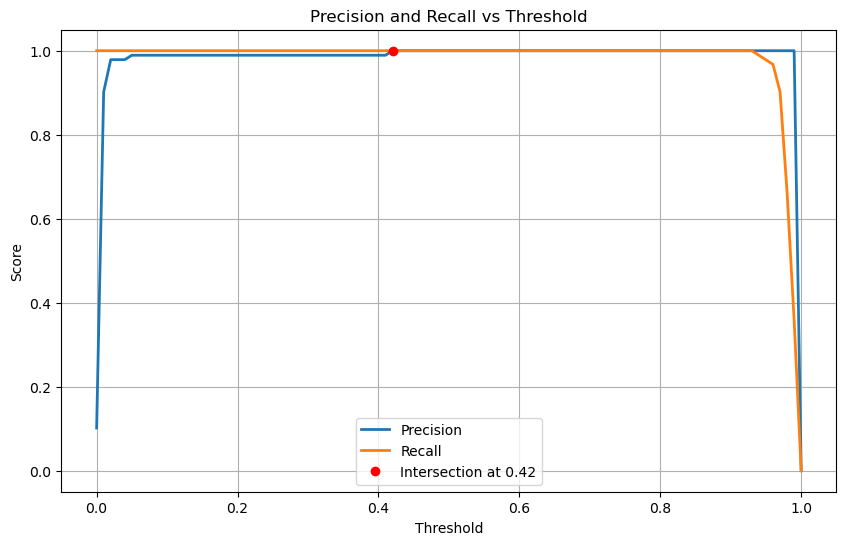

Precision and recall intersect at threshold = 0.42
At this threshold, precision = recall = 1.000


In [10]:
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np

# Generate thresholds from 0.0 to 1.0 with step 0.01
thresholds = np.arange(0, 1.01, 0.01)

precisions = []
recalls = []

# Calculate precision and recall for each threshold
for threshold in thresholds:
    # Convert probabilities to binary predictions using the threshold
    y_pred_binary = (y_pred >= threshold).astype(int)
    
    # Calculate precision and recall
    precision = precision_score(y_val, y_pred_binary)
    recall = recall_score(y_val, y_pred_binary)
    
    precisions.append(precision)
    recalls.append(recall)

# Convert to numpy arrays for easier manipulation
precisions = np.array(precisions)
recalls = np.array(recalls)

# Find intersection point
# The intersection occurs where the absolute difference between precision and recall is minimal
intersection_idx = np.argmin(np.abs(precisions - recalls))
intersection_threshold = thresholds[intersection_idx]
intersection_value = precisions[intersection_idx]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)
plt.grid(True)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()

# Mark intersection point
plt.plot(intersection_threshold, intersection_value, 'ro', label=f'Intersection at {intersection_threshold:.2f}')
plt.legend()

plt.show()

print(f"Precision and recall intersect at threshold = {intersection_threshold:.2f}")
print(f"At this threshold, precision = recall = {intersection_value:.3f}")

In [11]:
# Combine train and validation sets to create full training dataset
df_full_train = pd.concat([train, val])

# Convert target to numeric
y_full_train = (df_full_train['y'] == 'yes').astype(int)

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Store AUC scores for each fold
auc_scores = []

# Iterate through each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(df_full_train), 1):
    # Split data into train and validation for this fold
    df_train_fold = df_full_train.iloc[train_idx]
    df_val_fold = df_full_train.iloc[val_idx]
    
    y_train_fold = y_full_train.iloc[train_idx]
    y_val_fold = y_full_train.iloc[val_idx]
    
    # Convert to dict and apply DictVectorizer
    train_dict = df_train_fold.to_dict(orient='records')
    val_dict = df_val_fold.to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train_fold = dv.fit_transform(train_dict)
    X_val_fold = dv.transform(val_dict)
    
    # Train model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_fold, y_train_fold)
    
    # Make predictions and calculate AUC
    y_pred_fold = model.predict_proba(X_val_fold)[:, 1]
    auc = roc_auc_score(y_val_fold, y_pred_fold)
    auc_scores.append(auc)
    
    print(f"Fold {fold} AUC: {auc:.3f}")

# Calculate mean and standard deviation
auc_mean = np.mean(auc_scores)
auc_std = np.std(auc_scores)

print("\nSummary:")
print(f"Average AUC: {auc_mean:.3f} ± {auc_std:.3f}")
print(f"Standard deviation: {auc_std:.3f}")

Fold 1 AUC: 1.000
Fold 2 AUC: 1.000
Fold 3 AUC: 1.000
Fold 4 AUC: 1.000
Fold 5 AUC: 1.000

Summary:
Average AUC: 1.000 ± 0.000
Standard deviation: 0.000


In [12]:
# C values to test
C_values = [0.000001, 0.001, 1]

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Dictionary to store results for each C
results = {}

for C in C_values:
    auc_scores = []
    
    # Perform k-fold cross validation
    for fold, (train_idx, val_idx) in enumerate(kf.split(df_full_train), 1):
        # Split data into train and validation for this fold
        df_train_fold = df_full_train.iloc[train_idx]
        df_val_fold = df_full_train.iloc[val_idx]
        
        y_train_fold = y_full_train.iloc[train_idx]
        y_val_fold = y_full_train.iloc[val_idx]
        
        # Convert to dict and apply DictVectorizer
        train_dict = df_train_fold.to_dict(orient='records')
        val_dict = df_val_fold.to_dict(orient='records')
        
        dv = DictVectorizer(sparse=False)
        X_train_fold = dv.fit_transform(train_dict)
        X_val_fold = dv.transform(val_dict)
        
        # Train model with current C value
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_fold, y_train_fold)
        
        # Make predictions and calculate AUC
        y_pred_fold = model.predict_proba(X_val_fold)[:, 1]
        auc = roc_auc_score(y_val_fold, y_pred_fold)
        auc_scores.append(auc)
    
    # Calculate mean and std for current C value
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    
    # Store results
    results[C] = {
        'mean_auc': round(mean_auc, 3),
        'std_auc': round(std_auc, 3)
    }

# Print results
print("Results for each C value:")
print("\nC\t\tMean AUC ± Std")
print("-" * 40)
for C in C_values:
    print(f"{C:.6f}\t{results[C]['mean_auc']:.3f} ± {results[C]['std_auc']:.3f}")

# Find best C
best_C = max(results.items(), key=lambda x: x[1]['mean_auc'])[0]
print(f"\nBest C value: {best_C}")
print(f"Best mean AUC: {results[best_C]['mean_auc']:.3f}")

Results for each C value:

C		Mean AUC ± Std
----------------------------------------
0.000001	0.328 ± 0.051
0.001000	0.855 ± 0.044
1.000000	1.000 ± 0.000

Best C value: 1
Best mean AUC: 1.000
